In [4]:
#first we import all the necessary libraries

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F


In [6]:
#make our feed forward neural network
class DQN(nn.Module):
    def __init__(self , input_states , hidden_nodes , output_actions):
        super().__init__()
        
        #defining the layers
        self.fc1= nn.Linear(input_states , hidden_nodes)
        self.out= nn.Linear(hidden_nodes , output_actions)
        
    def forward(self , x ):
            x = F.relu(self.fc1(x)) #applying rectified linear output (ReLU) activation
            x= self.out(x)
            return x
        
#defining memory for experience replay
class Memory():
    def __init__ (self , maxlen) :
        self.memory = deque([] , maxlen=maxlen)
        
    def append(self , transition):
        self.memory.append(transition)
        
    def sample(self ,sample_size):
        return random.sample(self.memory , sample_size)
    
    def __len__(self):
        return len(self.memory)


In [7]:
# FrozenLake Deep Q-Learning
class FrozenLake():
    #defining our hyperparameter
    learning_rate = 0.001
    discount_factor = 0.9
    network_sync_rate = 10
    replay_memory_size = 10000
    mini_batch_size = 32
    
    # Neural Network
    loss_fn = nn.MSELoss()    #NN loss function MSE=Mean Squared Error
    optimizer= None   #we define the optimizer later
    def train(self , episodes , render = False , is_slippery = False ):
        
        #crete FrozenLake Instances
        env = gym.make( "FrozenLake-v1" ,  map_name ="4x4" , is_slippery = is_slippery , render_mode = "human" if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1 # initially we take totally random actions
        memory= Memory(self.replay_memory_size)
        
        #create policy and target network , number of hidden layer nodes same as observation space
        policy_dqn = DQN( input_states = num_states , hidden_nodes= num_states ,output_actions= num_actions)
        target_dqn = DQN( input_states = num_states , hidden_nodes= num_states ,output_actions= num_actions)
       
        #make the target and policy network the same
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        #initialize the optimizer "ADAM" optimizer
        self.optimizer = torch.optim.Adam( policy_dqn.parameters() , lr=self.learning_rate)
        
        #list to keep track of rewards collected over time initialized all to 0
        rewards_per_episode = np.zeros(episodes)
        
        #track the number of steps taken for syncing policy => target network
        step_count = 0
        
        for i in range (episodes):
            state = env.reset()[0] #initialize to state 0 
            terminated = False 
            truncated = False 
            
            #agent navigates until it reaches a terminal state or has taken 200 steps
            while(not terminated and not truncated):
                
                #using epsilon greedy
                
                if random.random() < epsilon:
                        #select random action
                        action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                else:
                        #select best action            
                        with torch.no_grad():
                            action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                #execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                #save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                #move to the next state
                state = new_state

                #increment step counter
                step_count+=1

           #keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1
            
            #check if there is enough experience has been collected and if at least 1 reward has been collected     
            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0 :
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch , policy_dqn , target_dqn)
                
                epsilon = max (epsilon - 1/episodes , 0 )
                
                #copy polciy network to target network after a certain number of states
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0
                
            #close the environment
            env.close()  
            
            #save the policy
            torch.save(policy_dqn.state_dict() , "frozen_lake_dqn.pt")    
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])
        plt.plot(sum_rewards)
        plt.savefig("frozen_lake_dqn.png")
        plt.show()
    
    def optimize(self , mini_batch , policy_dqn , target_dqn):
        
        #get the number of inputs
        num_states = policy_dqn.fc1.in_features
        
        current_q_list = []
        targer_q_list = []
        
        for state , action , new_state , reward , terminated in mini_batch:
            if terminated:
                #agent either reached the goal or fell into a hole
                target = torch.FloatTensor([reward])
            else :
                with torch.no_grad():
                    target=torch.FloatTensor( reward + self.discount_factor * target_dqn(self.state_to_dqn_input(new_state , num_states)).max()   )
            
            #get the current set of q values
            current_q = policy_dqn(self.state_to_dqn_input(state , num_states))
            current_q_list.append(current_q)
            
            #get the target set of q values
            target_q = target_dqn(self.state_to_dqn_input(state , num_states))
            
            #adjust the specific action to the target that was just calculated
            target_q[action] = target 
            targer_q_list.append(target_q)
            
        #compute loss for the whole mismatch
        loss = self.loss_fn(torch.stack(current_q_list) , torch.stack(targer_q_list))
        
        #optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor


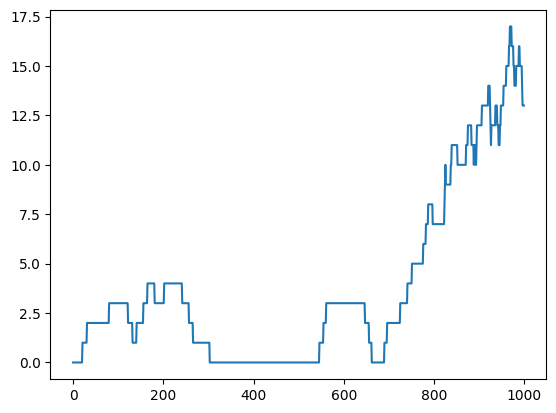

In [11]:
if __name__ == '__main__':

    frozen_lake = FrozenLake()
    is_slippery = True
    frozen_lake.train(1000, is_slippery=is_slippery)
